In [1]:
import numpy as np
import collections
import gzip
import random
import collections
import os
import sys
sys.path.append('../../scripts/')

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 16)


from scipy import stats
from scipy.interpolate import interp1d
#from statsmodels.stats import multitest

In [2]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

def read_vcf(filename, startsnp, endsnp):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    dsindx = linesplit[8].split(':').index("DS")
                    ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                    gtindx = linesplit[8].split(':').index("GT")
                    for i, x in enumerate(ds):
                        if x == ".":
                            gt = linesplit[9+i].split(':')[gtindx]
                            if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                ds[i] = float(int(gt[0]) + int(gt[2]))

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1

    return np.array(dosage), snpinfo, donor_ids


def read_gtex(rpkmfile):
    expr_list = list()
    donor_list = list()
    gene_list = list()
    with open(rpkmfile) as mfile:
        donor_list = mfile.readline().strip().split("\t")[1:]
        for line in mfile:
            linesplit = line.strip().split("\t")
            gene = linesplit[0].strip()
            gene_list.append(gene)
            expr = np.array([float(x) for x in linesplit[1:]])
            expr_list.append(expr)
    expr_list = np.transpose(np.array(expr_list))
    expr = np.transpose(np.array(expr_list))
    return expr, gene_list, donor_list

def normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

In [25]:
from sklearn.decomposition import PCA

def knn_correction(expr, dosage):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]))
    print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
    print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = 30
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        #noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn, neighbor_list

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtcent

def modify_gt_knn(gtsnp, neighbor_list):
    nsample = gtsnp.shape[0]
    kneighbor = 30
    gtmod = np.zeros_like(gtsnp)
    for i in range(nsample):
        neighbors = neighbor_list[i] #np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gtmod[i] = gtsnp[i] - np.mean(gtsnp[neighbors])
    gtmod = gtmod - np.mean(gtmod)
    return gtmod

In [26]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4

In [27]:
## Read genotype and gene expression
srcdir = "/scratch/sbanerj/trans-eqtl/simulation/16151_450_10_800_30_150_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02/sim008/input"
vcffile = os.path.join(srcdir, 'genotype.vcf.gz')
exprfile = os.path.join(srcdir, 'gx.txt')
gtffile = os.path.join(srcdir, 'expression.gtf.gz')
shuffile = os.path.join(srcdir, 'genotype.shuf')

gtfull, snp_info, gt_donors = read_vcf(vcffile, 0, 2000)
gxfull, gene_names, gx_donors = read_gtex(exprfile)
gx_norm = normalize_expr(gxfull)
gt_cent = normalize_and_center_dosage(gtfull, snp_info)

In [28]:
rand_donors = list()
with open(shuffile, 'r') as mfile:
    for line in mfile:
        rand_donors.append(line.strip())
rand_index = np.array([gt_donors.index(x) for x in rand_donors])
#gtfull_rand = gtfull[:, rand_index]
#gt_cent_rand = normalize_and_center_dosage(gtfull_rand, snp_info)

In [29]:
nsample = gx_norm.shape[1]

gx_corr, gt_corr, knn_neighbors = knn_correction(gx_norm.T, gtfull)
gx_knn = normalize_expr(gx_corr.T) #/ np.sqrt(nsample)
gt_knn = normalize_and_center_dosage(gt_corr, snp_info)

Original dimension: 450 x 16151
Reduced dimension: 450 x 10


In [30]:
#gx_corr_rand, gt_corr_rand, _ = knn_correction(gx_norm.T, gtfull_rand)
#gx_knn_rand = normalize_expr(gx_corr_rand.T) / np.sqrt(nsample)
#gt_knn_rand = normalize_and_center_dosage(gt_corr_rand, snp_info)
gt_knn_rand = gt_knn[:, rand_index]
gt_cent_rand = gt_cent[:, rand_index]

In [31]:
def format_matrix(header, matrix, rownames,
                  top_format, left_format, cell_format, row_delim, col_delim):
    table = [[''] + header] + [[name] + row for name, row in zip(rownames, matrix)]
    table_format = [['{:^{}}'] + len(header) * [top_format]] \
                 + len(matrix) * [[left_format] + len(header) * [cell_format]]
    col_widths = [max(
                      len(format.format(cell, 0))
                      for format, cell in zip(col_format, col))
                  for col_format, col in zip(zip(*table_format), zip(*table))]
    return row_delim.join(
               col_delim.join(
                   format.format(cell, width)
                   for format, cell, width in zip(row_format, row, col_widths))
               for row_format, row in zip(table_format, table))

====== KNN =======
          | Old version | with UX / UY
Eff. Rank |         448 |          448
    K_eff |     331.594 |      331.594
    S2[0] | 2.32182e+06 |  2.32182e+06
    S2[1] | 1.13716e+06 |  1.13716e+06
    S2[2] |      765211 |       765211
    S2[3] |      275352 |       275352
Sx2 / Sb2 |     40.6748 |      40.6748
   Qscore |     337.588 |      337.588
      muQ |     332.333 |      331.594
   sigmaQ |     9.30737 |      9.73419


====== Null model ======
             |  Mean   |  Std 
  Analytical | 332.333 | 9.307
With UX / UY | 331.594 | 9.734
   Empirical | 332.372 | 9.662


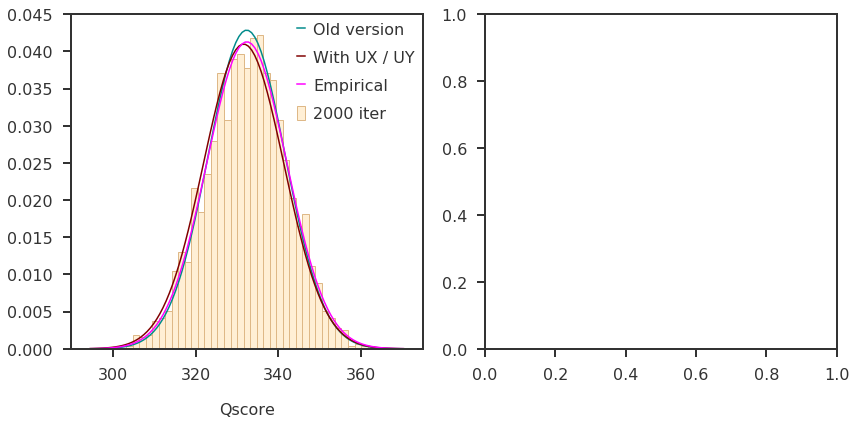

In [32]:
def shuffle_together(GX, GT, ax1, ax2):
    sigmabeta2 = 0.1 * 0.1
    niter = 2000
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    UGT = np.dot(U.T, GT)
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    mrank = len(np.where(S2 > 1e-4)[0])

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    W_U = np.diag(S2 / S2mod) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2 / S2mod) / sigmax2
    Qscore_U = np.sum(np.square(UGT) * S2 / S2mod) / sigmax2
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
    pval_U, muQ_U, sigmaQ_U = pvals_perm(UGT.reshape(1, -1), Qscore_U, W_U)

    
    Qiter = np.zeros(niter)
    permgt = GT.copy()

    for i in range(niter):
        np.random.shuffle(permgt)
        Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * S2 / S2mod) / sigmax2


    xmax = np.mean(Qiter) + 4.0 * np.std(Qiter)
    xmin = np.mean(Qiter) - 4.0 * np.std(Qiter)
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    
    ax1.hist(Qiter, bins = bins, density = True, label = '{:d} iter'.format(niter), 
             color = 'papayawhip', edgecolor = 'burlywood')
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax1.plot(x, rv.pdf(x), label = 'Old version', color = 'darkcyan')
    rv_U = stats.norm(loc = muQ_U, scale = sigmaQ_U)
    ax1.plot(x, rv_U.pdf(x), label = 'With UX / UY', color = 'maroon')
    rv_emp = stats.norm(loc = np.mean(Qiter), scale = np.std(Qiter))
    ax1.plot(x, rv_emp.pdf(x), label = 'Empirical', color = 'magenta')
    ax1.set_xlabel('Qscore')
    ax1.legend()
    
#     ax2.scatter(Qiter, Qiter_U, s = 2)
#     ax2.set_xlabel('Q (old version)')
#     ax2.set_ylabel('Q (with UX / UY)')
    
    print ("====== KNN =======")
    print (format_matrix(['Old version', 'with UX / UY'],
                         [[mrank, mrank], [np.sum(S2 / S2mod), np.sum(S2 / S2mod)], 
                          [S2[0], S2[0]], [S2[1], S2[1]], [S2[2], S2[2]], [S2[3], S2[3]], 
                          [sigmax2 / sigmabeta2, sigmax2 / sigmabeta2], 
                          [Qscore, Qscore_U], [muQ, muQ_U], [sigmaQ, sigmaQ_U]],
                         ['Eff. Rank', 'K_eff', 'S2[0]', 'S2[1]', 'S2[2]', 'S2[3]', 'Sx2 / Sb2', 
                          'Qscore', 'muQ', 'sigmaQ'],
                         '{:^{}}', '{:>{}}', '{:>{}g}', '\n', ' | '))
    print("")
    print("")
    
    print ("====== Null model ======")
    print (format_matrix(['Mean', 'Std'],
                         [[muQ, sigmaQ], [muQ_U, sigmaQ_U], [np.mean(Qiter), np.std(Qiter)]],
                         ['Analytical', 'With UX / UY', 'Empirical'],
                         '{:^{}}', '{:>{}}', '{:>{}.3f}', '\n', ' | '))
    
    return Qiter

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

Qiter = shuffle_together(gx_knn, gt_knn[5, :], ax1, ax2)

plt.tight_layout()
plt.show()

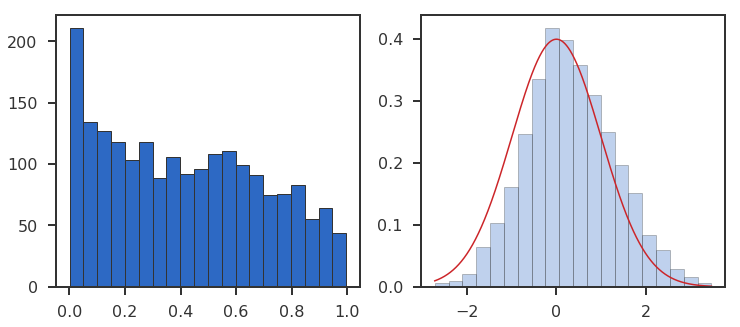

In [33]:
# Plot it for all SNPs

nsnps = gt_knn.shape[0]
pvals = list()
qstat = list()
qmean = list()
qvars = list()
qscale = list()

sigmabeta2 = 0.01 * 0.01
Yt = gx_knn.T
#Yt = gx_norm.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2 = np.square(S)


for i in range(nsnps):
    gt = gt_knn[i, :].copy()
    #gt = gt_cent[i, :].copy()
    #gt = gt_cent_rand[i, :].copy()
    sigmax2 = np.var(gt)
    S2mod = S2 + sigmax2 / sigmabeta2

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, gt)) * S2 / S2mod) / sigmax2
    pval, muQ, sigmaQ = pvals_perm(gt.reshape(1, -1), Qscore, W)
    scaledQ = (Qscore - muQ) / sigmaQ
    
    pvals.append(pval)
    qstat.append(Qscore)
    qmean.append(muQ)
    qvars.append(sigmaQ)
    qscale.append(scaledQ)

from scipy import stats

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(pvals)
ax2.hist(qscale, alpha = 0.3, density = True)


xmin = min(qscale)
xmax = max(qscale)
xvals = np.linspace(xmin, xmax, 10000)
yvals = stats.norm.pdf(xvals)
ax2.plot(xvals, yvals)


plt.show()

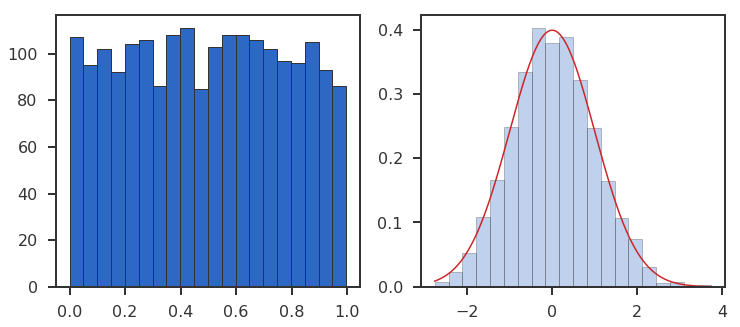

In [34]:
# Plot it for all SNPs

nsnps = gt_knn.shape[0]
pvals_rand = list()
qstat_rand = list()
qmean_rand = list()
qvars_rand = list()
qscale_rand = list()

sigmabeta2 = 0.01 * 0.01
Yt = gx_knn.T
#Yt = gx_norm.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2 = np.square(S)


for i in range(nsnps):
    gt = gt_knn_rand[i, :].copy()
    #gt = gt_cent_rand[i, :].copy()
    sigmax2 = np.var(gt)
    S2mod = S2 + sigmax2 / sigmabeta2

    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) / sigmax2
    Qscore = np.sum(np.square(np.dot(U.T, gt)) * S2 / S2mod) / sigmax2
    pval, muQ, sigmaQ = pvals_perm(gt.reshape(1, -1), Qscore, W)
    scaledQ = (Qscore - muQ) / sigmaQ
    
    pvals_rand.append(pval)
    qstat_rand.append(Qscore)
    qmean_rand.append(muQ)
    qvars_rand.append(sigmaQ)
    qscale_rand.append(scaledQ)

from scipy import stats

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(pvals_rand)
ax2.hist(qscale_rand, alpha = 0.3, density = True)


xmin = min(qscale_rand)
xmax = max(qscale_rand)
xvals = np.linspace(xmin, xmax, 10000)
yvals = stats.norm.pdf(xvals)
ax2.plot(xvals, yvals)


plt.show()

In [53]:
def replace_zero_pvals(p):
    q = np.array(p).copy()
    qmin = np.min(q[q>0])
    q[q==0] = qmin
    return q

pvals = replace_zero_pvals(pvals)
pvals_rand = replace_zero_pvals(pvals_rand)

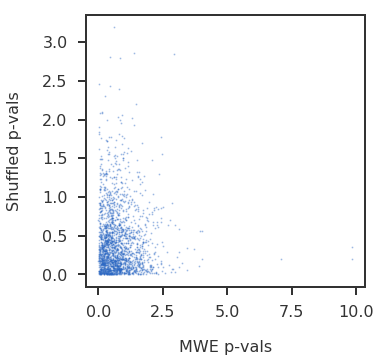

In [54]:
fig = plt.figure(figsize = (5, 5))
ax1 = fig.add_subplot(111)
ax1.scatter(-np.log10(pvals), -np.log10(pvals_rand), s=1, alpha = 0.3)
#ax1.scatter(pvals, pvals_rand, s=1, alpha=0.3)
ax1.set_ylabel("Shuffled p-vals")
ax1.set_xlabel("MWE p-vals")
plt.show()

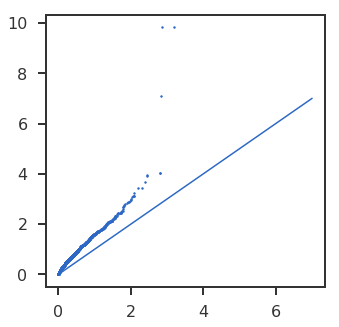

In [55]:
# Q-Q plot
fig = plt.figure(figsize = (5, 5))
ax1 = fig.add_subplot(111)

prand_sort = np.sort(pvals_rand)
pvals_sort = np.sort(pvals)

ax1.scatter(-np.log10(prand_sort), -np.log10(pvals_sort), s = 2)
ax1.plot([0, 7], [0,7])

plt.show()

In [56]:
np.where(pvals < 1e-5)

(array([  41,  322, 1663]),)

In [36]:
for i, snp in enumerate(snp_info):
    if snp.varid in ['rs7537362', 'rs6588014', 'rs2971828']:
        print(snp.varid, pvals[i])

rs7537362 0.0013211079412429605
rs6588014 1.5685456702829725e-05
rs2971828 8.881784197001252e-16


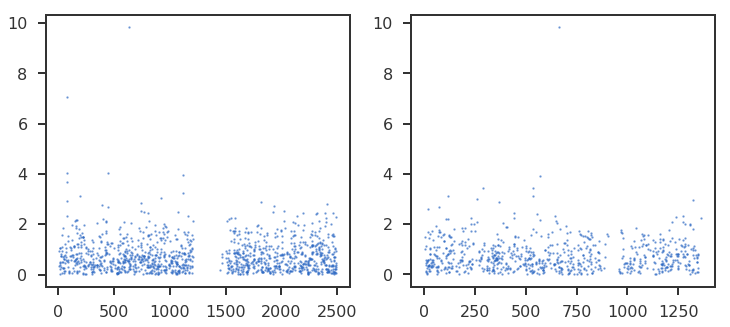

In [19]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bppos = [list(), list()]
for i, snp in enumerate(snp_info):
    bppos[int(snp.chrom) - 1].append(float(snp.bp_pos))

onemb = 100000
ax1.scatter(np.array(bppos[0]) / onemb, -np.log10(pvals[:len(bppos[0])]), s = 2, alpha = 0.5)
ax2.scatter(np.array(bppos[1]) / onemb, -np.log10(pvals[len(bppos[0]):]), s = 2, alpha = 0.5)
plt.show()

In [20]:
pvals

array([0.45821735, 0.11267639, 0.91492929, ..., 0.15630737, 0.78709652,
       0.00576698])

In [17]:
cis_genes = list()
with open(os.path.join(srcdir, 'cismask.txt'), 'r') as mfile:
    for line in mfile:
        cis_genes.append(int(line.strip()))
cis_genes = np.array(cis_genes)

mask = np.ones(16151, dtype=bool)
mask[cis_genes] = False